In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

sys.path.append(r"../")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath, multidevice, groutine, misc
from CrystalDiff.SplitDelayCrystalModel import get_crystal_in_delay_fixed_branch, get_crystals_in_delayed_branch
from CrystalDiff.SplitDelayCrystalModel import align_delay_fixed_branch, align_delayed_branch, get_light_path

# Define the pulse and grating

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Grating
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.25)
grating_list[0].set_b(0.25)
grating_list[1].set_a(0.25)
grating_list[1].set_b(0.25)


# -----------------------
#   Set spatial position
# -----------------------
# Grating_position_1
g_position_1 = np.array([252.70, 660.04, 140.04]) * 1000 + np.array([0, 652.5484, -2.9e6])
grating_list[0].set_surface_point(g_position_1)

g_position_2 = np.array([252.63, 659.55, 1065.14]) * 1000 + np.array([0, -652.5484, 2.1e6])
grating_list[1].set_surface_point(g_position_2)


# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 9.5  # keV
pre_length = 1e6    # Distance of the pulse from the first grating

# Set up the pulse
FWHM = 100 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=9.12,
                              x0=g_position_1 - np.array([0., 0., pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                      Grating splitting angle
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.

# Define and align crystals

In [3]:
lattice_distance = 1.9201 * 1e-4   # Lattice plane distance in um

chi_dict = {"chi0": complex(-0.10826E-04, 0.18209E-06 ),
            "chih_sigma": complex(0.65800E-05, -0.17530E-06  ),
            "chihbar_sigma": complex(0.65800E-05, -0.17530E-06  ),
            "chih_pi": complex(0.50600E-05, -0.13313E-06),
            "chihbar_pi": complex(0.50600E-05, -0.13313E-06)
            }

# Crystal in Delayed branch
crystal_list_1 = get_crystals_in_delayed_branch(asymmetric_angles=np.deg2rad(np.array([0,-5,5,0,
                                                                                       0,5,-5,0])),
                                               lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

# Crystal in Delay fixed branch
crystal_list_2 = get_crystal_in_delay_fixed_branch(lattice_distance=lattice_distance,
                                               chi_dict=chi_dict)

###################################################################
#    Align the crystals
###################################################################
# Bragg angle
bragg = np.radians(19.868)

#################################################################
#        Delayed Branch
#################################################################
crystal_list_1 = align_delayed_branch(delayed_branch_crystals = crystal_list_1,
                                      angle_offset = dtheta,
                                      bragg = bragg + 530e-6,
                                      tweak = np.array([0,-1035e-6,-1035e-6,0]))

#################################################################
#        Delay-fixed Branch
#################################################################
crystal_list_2 = align_delay_fixed_branch(delay_fixed_branch_crystals = crystal_list_2,
                                          angle_offset = -dtheta,
                                          bragg =  bragg + 533e-6,
                                          tweak = 1045e-6)

# Tune crystal positions to achieve spatial and temporal overlap

In [4]:
t23_motion = 1263.0686890313366
t5_motion = -358.

(new_path_upper,
 new_path_lower,
 new_crystal,
 new_crystal_lower) = get_light_path(ref_crystal_up = crystal_list_1,
                                     ref_crystal_low = crystal_list_2,
                                     ref_grating = grating_list,
                                     ref_pulse = my_pulse,
                                     shift_upper = np.array([2325.5 - 360 + t23_motion, ] * 2 +
                                                            [-2325.5 - 360 + t23_motion,] * 2 + 
                                                            [0,] * 2 +
                                                            [3961 + t5_motion,] * 2),
                                     shift_lower = [0,] * 2 + [1900,]*2)

In [5]:
print("-------------------------------")
print("Grating position: ")
print("New upper: {:.4f}".format(new_path_upper[0][-2, 1]))
print("New lower: {:.4f}".format(new_path_lower[0][-2, 1]))

print("-------------------------------")
print("Light Path position: ")
print("New upper: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])))
print("New lower: {:.4f}".format(util.get_total_path_length(new_path_lower[0][:-1])))
print("Difference: {:.4f}".format(util.get_total_path_length(new_path_upper[0][:-1])
                                 -util.get_total_path_length(new_path_lower[0][:-1])))

-------------------------------
Grating position: 
New upper: 660568.1885
New lower: 660368.6155
-------------------------------
Light Path position: 
New upper: 6960184.8301
New lower: 6959732.0458
Difference: 452.7843


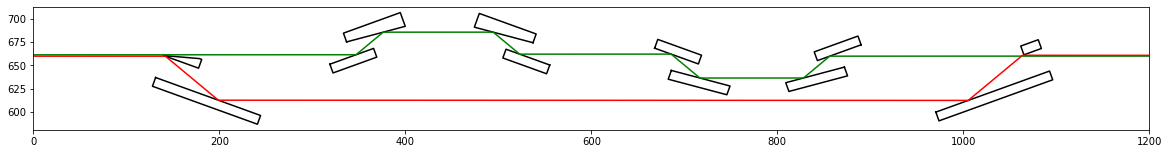

In [6]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([new_crystal[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')
    
for x in range(4):
    ax.plot([new_crystal_lower[x].boundary[y][2]/1000 for y in [0, 1, 2, 3, 0]],
             [new_crystal_lower[x].boundary[y][1]/1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(new_path_upper[0][:,2]/1000,
        new_path_upper[0][:,1]/1000,'g')

ax.plot(new_path_lower[0][:,2]/1000,
        new_path_lower[0][:,1]/1000,'r')

ax.set_aspect("equal")
ax.set_xlim([0, 1200])

plt.show()

# Get the 2D field

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 2 ** 9
number_z = 2 ** 15
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=5e-4,
                                                          delta_e_z=2e-3)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

# Apply fft shift
#kx_grid = np.zeros(1, np.float64)
#number_x = 1
#ky_grid = np.zeros(1, np.float64)
#number_y = 1
#kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

In [8]:
total_path = 20e6
observation = new_path_upper[0][-1]

crystal_list = list(range(10))
crystal_list[0] = grating_list[0]
crystal_list[1:-1] = new_crystal[:]
crystal_list[-1] = grating_list[1]

# Set the range of the index to save
z_idx_range = number_z
num1 = 800
num2 = z_idx_range - num1
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_var,
 result_2d_var,
 check_var
) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                 total_path = total_path, 
                                 observation = observation,
                                 my_pulse = my_pulse,
                                 kx_grid = kx_grid,
                                 ky_grid = ky_grid,
                                 kz_grid = kz_grid,
                                 pulse_delay_time = 0.,
                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                 grating_orders = [1.,-1],
                                 number_x = number_x,
                                 number_y = number_y,
                                 number_z = number_z,
                                 z_idx_range = z_idx_range,
                                idx_start_1=number_z - num1,
                                idx_start_2=0,
                                 num1 = num1,
                                 num2 = num2, 
                                 d_num = 512)


toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.55 seconds to prepare the variables.
It takes 28.95 seconds to get the field for branch 1.


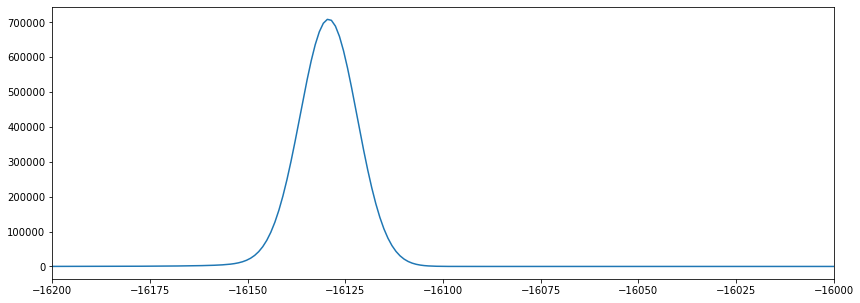

In [9]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(14)

axes.plot(axis_info["z_time_idx"], np.sum(np.square(np.abs(result_3d_var['efield_3d'])), axis=(0,1,3)))
axes.set_xlim([-16200, -16000])
plt.show()

In [10]:
misc.get_fwhm(axis_info['z_time_idx'], np.sum(np.square(np.abs(result_3d_var['efield_3d'])), axis=(0,1,3)))

16.542670648206695

In [11]:
total_path = 20e6
observation = new_path_upper[0][-1]

crystal_list = list(range(6))
crystal_list[0] = grating_list[0]
crystal_list[1:-1] = new_crystal_lower[:]
crystal_list[-1] = grating_list[1]

# Set the range of the index to save
z_idx_range = number_z
num1 = 800
num2 = z_idx_range - num1
d_num = 512

# -------------------------------------------------------------
#            Get Field for variable branch
# -------------------------------------------------------------
tic = time.time()

(result_3d_fix,
 result_2d_fix,
 check_fix
) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                 total_path = total_path, 
                                 observation = observation,
                                 my_pulse = my_pulse,
                                 kx_grid = kx_grid,
                                 ky_grid = ky_grid,
                                 kz_grid = kz_grid,
                                 pulse_delay_time = 0.,
                                 pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                 grating_orders = [-1.,1],
                                 number_x = number_x,
                                 number_y = number_y,
                                 number_z = number_z,
                                 z_idx_range = z_idx_range,
                                   idx_start_1=number_z - num1,
                                   idx_start_2=0,
                                 num1 = num1,
                                 num2 = num2, 
                                 d_num = 512)


toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.44 seconds to prepare the variables.
It takes 18.92 seconds to get the field for branch 1.


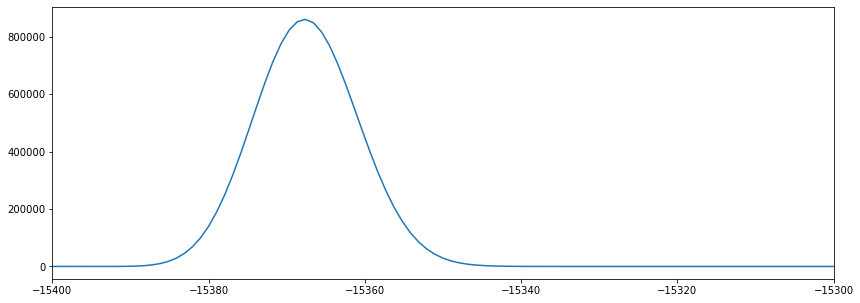

In [22]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(5)
fig.set_figwidth(14)

axes.plot(axis_info["z_time_idx"], np.sum(np.square(np.abs(result_3d_fix['efield_3d'])), axis=(0,1,3)))
axes.set_xlim([-15400, -15300])
plt.show()

In [13]:
misc.get_fwhm(axis_info['z_time_idx'], np.sum(np.square(np.abs(result_3d_fix['efield_3d'])), axis=(0,1,3)))

14.474836817182222

In [14]:
# Calculate the incident total energy
#energy_in = 8 * np.pi ** 2 * (FWHM /2. / np.sqrt(np.log(2)) / util.c) ** 2 * util.c **2

energy_in = my_pulse.scaling ** 2 * np.pi / np.sqrt(my_pulse.sigma_mat[1,1]) / np.sqrt(my_pulse.sigma_mat[2,2])


# Calculate the energy of the branch with variable delay time
energy_var = np.sum(np.square(np.abs(result_3d_var['efield_spec_3d']))) * (kz_grid[1] - kz_grid[0]) * (ky_grid[1] - ky_grid[0]) 
# Calculate the energy of the branch with fixed delay time
energy_fix = np.sum(np.square(np.abs(result_3d_fix['efield_spec_3d']))) * (kz_grid[1] - kz_grid[0]) * (ky_grid[1] - ky_grid[0])

print("The efficiency of the branch with a variable delay time is {:.3f}.".format(energy_var / energy_in))
print("The efficiency of the branch with a fixed delay time is {:.3f}.".format(energy_fix / energy_in))

The efficiency of the branch with a variable delay time is 0.124.
The efficiency of the branch with a fixed delay time is 0.135.


In [15]:
(0.124 +0.135)

0.259

# Add absorptions and get the energy efficiency
Here, vcc means the delayed branch. cc means the delay-fixed branch.

In [16]:
# Initial energy efficiency 
vcc_eff_init = energy_var / energy_in
cc_eff_init = energy_fix / energy_in

##################################################################################
#       Kapton coef
##################################################################################
# Get the kapton efficiency
kapton_absorb_coef = 2257.9 # um
vcc_kapton_length = 30 * 6 + 125 + 3 * 50.
cc_kapton_length = 30 * 6 + 100.

# Get the coeff
vcc_kapton_coef = np.exp(- vcc_kapton_length / kapton_absorb_coef)
cc_kapton_coef = np.exp(- cc_kapton_length / kapton_absorb_coef)

##################################################################################
#        Air coef
##################################################################################
air_absorb_length = 0.618 # -np.log(0.532)
air_length = 0.5 + 1.2 * 0.1 # Conver the air path in the helium to pure air
air_coef = np.exp(-air_length * air_absorb_length)

##################################################################################
#        Diamend coef
##################################################################################
diamond_absorption_factor = - 7.3453
diamond_absorption_factor /= 1e4  # Convert to um
diamond_thickness =  60 + 2 * 100. / np.cos(np.deg2rad(72))

diamond_absorption_coef = np.exp(diamond_absorption_factor * diamond_thickness)

###########################################################
#      Calculate the overall energy efficiency
###########################################################
overall_energy_efficiency = vcc_eff_init * vcc_kapton_coef * air_coef * diamond_absorption_coef
overall_energy_efficiency += cc_eff_init * cc_kapton_coef * air_coef * diamond_absorption_coef

###########################################################
#      Compensate for the imperfection of the grating shape
###########################################################
overall_energy_efficiency = overall_energy_efficiency * (0.2 / 0.32) ** 2

print("The overall energy efficiency of the device is :{:.2f}%".format(overall_energy_efficiency * 100))

The overall energy efficiency of the device is :3.50%


# Calculate the energy efficiency of the Channel-cut crystals only

In [17]:
# Initial energy efficiency 
vcc_eff_init = energy_var / energy_in
cc_eff_init = energy_fix / energy_in

##################################################################################
#       Kapton coef
##################################################################################
# Get the kapton efficiency
kapton_absorb_coef = 2257.9 # um
vcc_kapton_length = 30 * 2 + 125 + 3 * 50.
cc_kapton_length = 30 * 2 + 100.

# Get the coeff
vcc_kapton_coef = np.exp(- vcc_kapton_length / kapton_absorb_coef)
cc_kapton_coef = np.exp(- cc_kapton_length / kapton_absorb_coef)

##################################################################################
#        Air coef
##################################################################################
air_absorb_length = 0.618
air_length = 0.1 + 1.2 * 0.1 # Conver the air path in the helium to pure air
air_coef = np.exp(-air_length * air_absorb_length)

##################################################################################
#        Diamend coef
##################################################################################
diamond_absorption_factor = - 7.3453
diamond_absorption_factor /= 1e4  # Convert to um

diamond_thickness =  60

diamond_absorption_coef = np.exp(diamond_absorption_factor * diamond_thickness)

###########################################################
#      Calculate the Channel-cut efficiency
###########################################################
sd_table_efficiency = vcc_eff_init * vcc_kapton_coef * air_coef * diamond_absorption_coef
sd_table_efficiency = sd_table_efficiency + cc_eff_init * cc_kapton_coef * air_coef * diamond_absorption_coef

# Remove the grating effect
sd_table_efficiency /= 0.4 ** 2

sd_table_efficiency /= 2.

print("SD table efficiency is :{:.2f}%".format(sd_table_efficiency * 100))

SD table efficiency is :60.88%
